# Car Prowls Trouble Seattle Nights

While the assumption that more crimes are committed at night than during the day seems self-evident, I want to analyze the prevalence of car prowls by time of day. Car prowls are the most common reported incident (at least according to the "Seattle Summer 2014" dataset) &mdash; with nearly twice the number of reported incidents as the runner-up, property incidents.

To analyze the distribution of car prowls by time of day, I've grouped the reported incidents by their occurrence date, aggregating the incidents into 2-hour periods so the resulting statistics is easier to interpret. For every 2-hour period of the time of the day, I've then computed the average number of reported incidents over all days, as well as the average number of reported car prowls.

In [2]:
import datetime as dt
import pandas as pd
import numpy as np

seattle = pd.read_csv('seattle_incidents_summer_2014.csv', parse_dates = True)
seattle.index = pd.to_datetime(seattle['Occurred Date or Date Range Start'])

# Compute the counts of reported offenses for every 2h bin.
#
binned = (seattle[['Occurred Date or Date Range Start', 'Summarized Offense Description']]
          .groupby([pd.TimeGrouper(freq = '2H'), 'Summarized Offense Description'])
          .size()
          .reset_index()
          .rename(columns = {'Occurred Date or Date Range Start' : 'Date',
                             'Summarized Offense Description' : 'Offense',
                             0 : 'Count'}))

# Compute the total number of reported offenses for every 2h bin.
#
totals = (binned.groupby(['Date'])
          .sum()
          .rename(columns = {'Count' : 'Total'}))

# Filter by car prowl offenses only, and append totals column.
car_prowls = (binned[binned.Offense == 'CAR PROWL']
              .set_index('Date'))
car_prowls['Total'] = totals['Total']
car_prowls['Fraction'] = car_prowls.Count / car_prowls.Total

hours = [dt.time(hour) for hour in range(0, 24, 2)]
bin_means = [car_prowls.between_time(hour, hour)[['Count', 'Total', 'Fraction']]
             .mean().values for hour in hours]

car_prowl_binned = pd.DataFrame(bin_means, hours, columns = ['Car Prowl Average', 'Total Average', 'Total Share'])

# Compute fraction of car prowls per time of day
car_prowl_total = car_prowl_binned['Car Prowl Average'].sum()
car_prowl_binned['Car Prowl Fraction'] = car_prowl_binned['Car Prowl Average'] / car_prowl_total

/usr/lib/python3.4/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


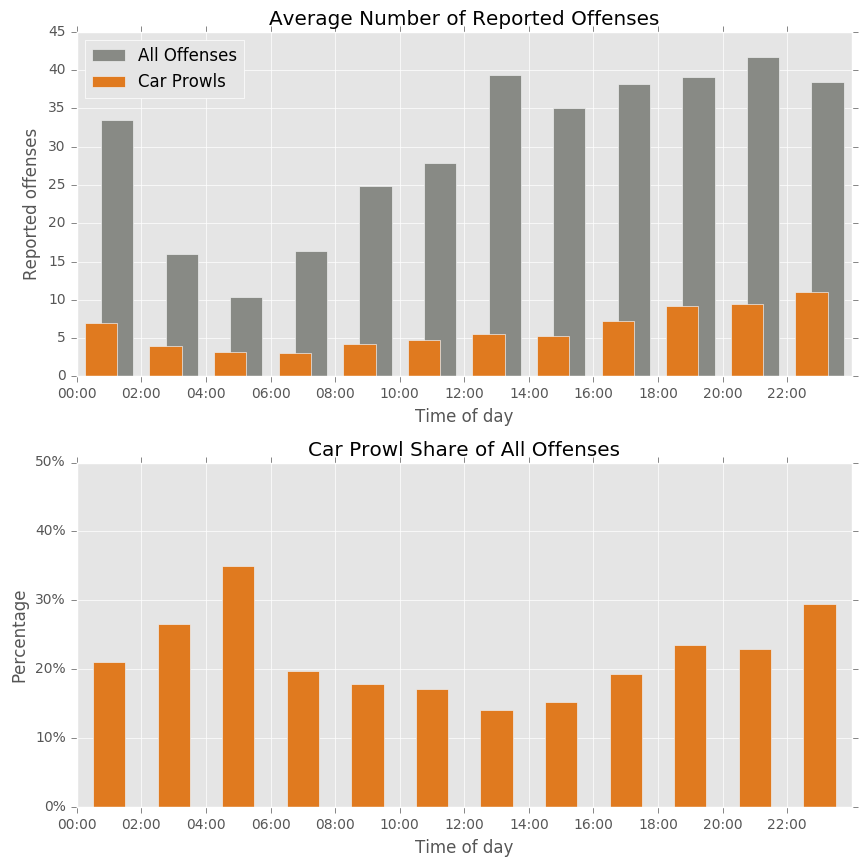

In [3]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')

fig, axes = plt.subplots(ncols = 1, nrows = 2)
fig.set_size_inches(10, 10)
plt.subplots_adjust(hspace = 0.25)

plt.subplot(2, 1, 1)

bar_width = 1.0
xs = np.arange(0, 24, 2)
xs_labels = [time_of_day.strftime('%H:%M') for time_of_day in car_prowl_binned.index.values]

total_bars = plt.bar(0.75 * bar_width + xs, car_prowl_binned['Total Average'],
                     width = bar_width, color = '#888a85')
car_prowl_bars = plt.bar(0.25 * bar_width + xs, car_prowl_binned['Car Prowl Average'],
                         width = bar_width, color = '#e07a1f')
plt.title('Average Number of Reported Offenses')
plt.xlabel('Time of day')
plt.ylabel('Reported offenses')
plt.xlim(0, 24)
plt.xticks(xs, xs_labels)
legend = plt.legend((total_bars[0], car_prowl_bars[0]), ('All Offenses', 'Car Prowls'), loc = 'upper left')
#legend.get_frame().set_facecolor('#eeeeec')


plt.subplot(2, 1, 2)

plt.bar(0.5 * bar_width + xs, car_prowl_binned['Total Share'],
        width = bar_width, color = '#e07a1f')
plt.title('Car Prowl Share of All Offenses')
plt.xlabel('Time of day')
plt.ylabel('Percentage')
plt.xlim(0, 24)
plt.xticks(xs, xs_labels)
plt.ylim(0, 0.5)
plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5], ['0%', '10%', '20%', '30%', '40%', '50%'])

plt.show()

Looking at these figures, one can see that the average number of reported offenses is at its lowest in the early morning, i.e., between 4:00 and 6:00. It then increases until 12:00, and remains at an average of 35&ndash;45 reported offenses until midnight, when it starts to go down again quite drastically.

The average number of reported car prowls seems to follow a similar pattern, though given that car prowls are only one many different types of offenses, the first figure does not allow to assess whether the average number of car prowls might exhibit a different pattern than the average number of all offenses. Thus the second figure shows the number of car prowls as a _percentage_ of all reported offenses. From this figure, one can see that the share of car prowls in all offenses is larger in the evening and at night&mdash;i.e., between 18:00 and 6:00&mdash;than during the day, although the difference is not that pronounced. The peak that can be observed between 4:00 and 6:00 is probably an artifact, as the average number of offenses is at a minimum during that time of the day (cf. first figure), and small variations in the number of reported car prowls vs. all other offenses will therefore cause large variations in the car prowl percentage.

To be able to asses how car prowl prevalence varies during the day, the third figure below depicts the percentage of car prowls committed during the various times of the day. One can clearly see that many more car prowls occurr at night (between 18:00 and 0:00), and that the fewest car prowls are committed in the (early) morning, between 4:00 and 8:00.

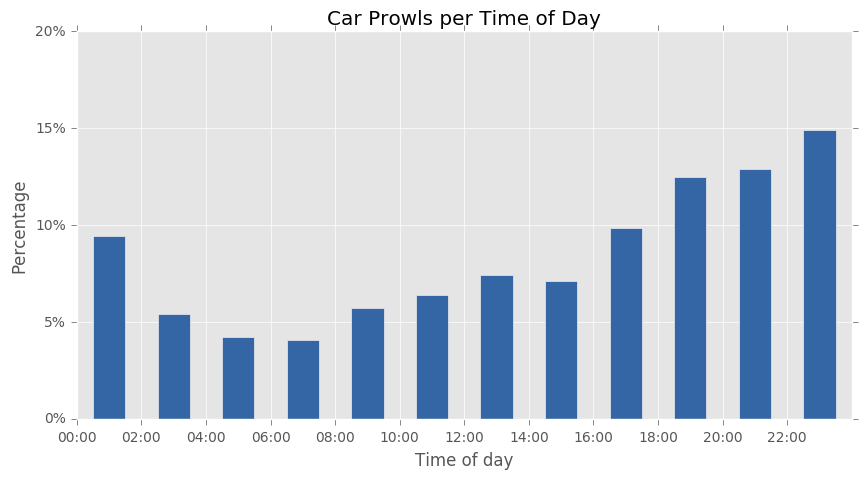

In [4]:
plt.figure(figsize=(10, 5))

bar_width = 1.0
xs = np.arange(0, 24, 2)
xs_labels = [time_of_day.strftime('%H:%M') for time_of_day in car_prowl_binned.index.values]

plt.bar(0.5 * bar_width + xs, car_prowl_binned['Car Prowl Fraction'],
        width = bar_width, color = '#3465a4')
plt.title('Car Prowls per Time of Day')
plt.xlabel('Time of day')
plt.ylabel('Percentage')
plt.xlim(0, 24)
plt.xticks(xs, xs_labels)
plt.ylim(0, 0.2)
plt.yticks([0.0, 0.05, 0.1, 0.15, 0.2], ['0%', '5%', '10%', '15%', '20%'])

plt.show()

It is also interesting to note that car prowl prevalence only starts increasing after 16:00, whereas the overall number of offenses has already peaks between 12:00 and 14:00. This indicates that other offenses dominate the early afternoon, which is confirmed by the low car prowl share for that time of the day, see figure two.